In [87]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [107]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Mon Feb 12 15:52:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              N/A /  20W |   1972MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [151]:
num_heads = 5

alpha_bounds = (1, 10)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)


omega_bounds = (0, np.pi)
def generate_omega(k, omega_bounds = omega_bounds):
  omega_list = np.zeros(k)
  for i in range(k):
    omega_list[i] = np.random.uniform(omega_bounds[0], omega_bounds[1])
  return omega_list
omega_list = generate_omega(num_heads)


def get_A(alpha):
    return torch.tensor([[2., -1.], [1-alpha, alpha]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

def random_IC(x_bound=[0, 2], y_bound=[8, 12]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev).double()
#IC_list = [random_IC() for _ in range(num_heads)]
IC_list = [torch.tensor([[2.], [4.]], device=dev).double() for _ in range(num_heads)]

def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev).double()
#force_list = [random_force() for i in range(num_heads)]
#force_list =  [lambda t, i=i: [2*torch.sin(t), i*(torch.cos(t)-torch.sin(t))] for i in alpha_list]

force_list = [
    lambda t, alpha=a, omega=w: torch.vstack([2*torch.sin(omega*t), alpha*(torch.cos(omega*t)-torch.sin(omega*t))]).T.double()
    if not isinstance(t, (float, int))
    else np.array([2*np.sin(omega*t), alpha*(np.cos(omega*t)-np.sin(omega*t))]).T
    for a, w in zip(alpha_list, omega_list)
]

equation_name = "linear_exemple1"

In [157]:
omega_list

array([2.36090035, 1.90842823, 2.59444808, 0.93323029, 1.204341  ])

In [152]:
x_range = [0, 10]
activation = "silu"
hid_lay = list(np.array([124, 124, 132]))
num_equations = 2
iterations = 40000

In [153]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[..., 0].item()- A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[..., 1].item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

In [154]:
lr = 0.0001
verbose = True
sample_size = 200
decay=True

loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr, A_list=A_list, 
                                                     v_list=IC_list, force=force_list, hid_lay=hid_lay, activation=activation,
                                                     num_equations=num_equations, num_heads=num_heads, sample_size=sample_size,
                                                     decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/40000 [00:00<?, ?it/s]

Iterations 0, L_total = 40.18477267826223, L_ODE = 30.384636506167794, L_IC = 9.800136172094435
Iterations 100, L_total = 31.066175160569504, L_ODE = 25.201737237213905, L_IC = 5.8644379233556
Iterations 200, L_total = 27.498691592415092, L_ODE = 25.307593716843495, L_IC = 2.191097875571598
Iterations 300, L_total = 25.03576581501088, L_ODE = 23.919721552049744, L_IC = 1.1160442629611367
Iterations 400, L_total = 24.40216872752982, L_ODE = 23.66575328549614, L_IC = 0.7364154420336777
Iterations 500, L_total = 20.732551487102793, L_ODE = 20.14998653574603, L_IC = 0.5825649513567622
Iterations 600, L_total = 20.73699354403974, L_ODE = 20.27570768145365, L_IC = 0.4612858625860928
Iterations 700, L_total = 20.406714901062838, L_ODE = 20.04893537834195, L_IC = 0.3577795227208871
Iterations 800, L_total = 19.66838118533342, L_ODE = 19.38737050420901, L_IC = 0.2810106811244114
Iterations 900, L_total = 18.393524204827955, L_ODE = 18.16199338749504, L_IC = 0.23153081733291475
Iterations 1000, 

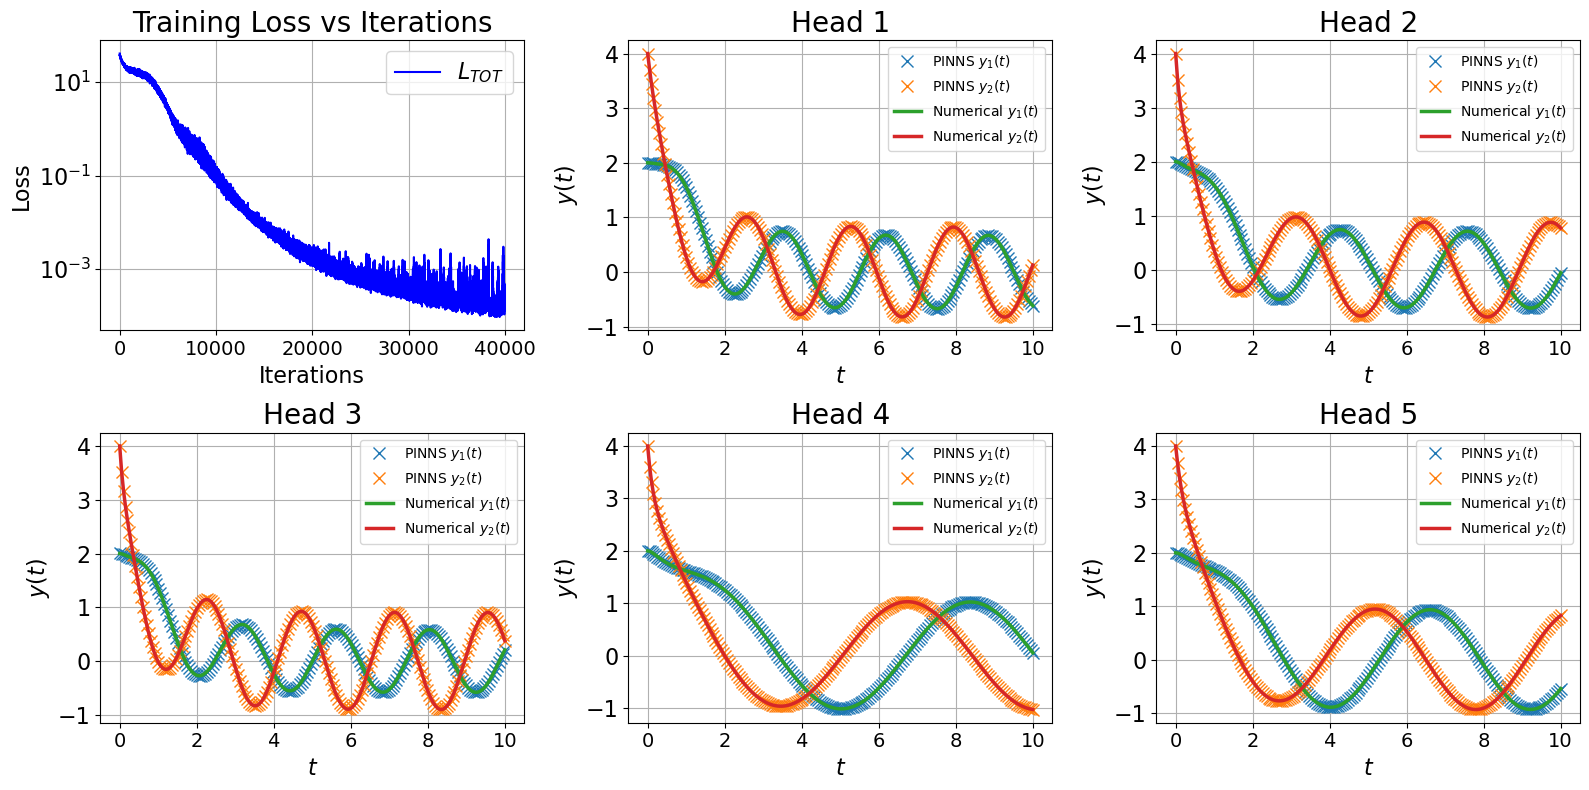

In [155]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,  
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist,  device=dev)

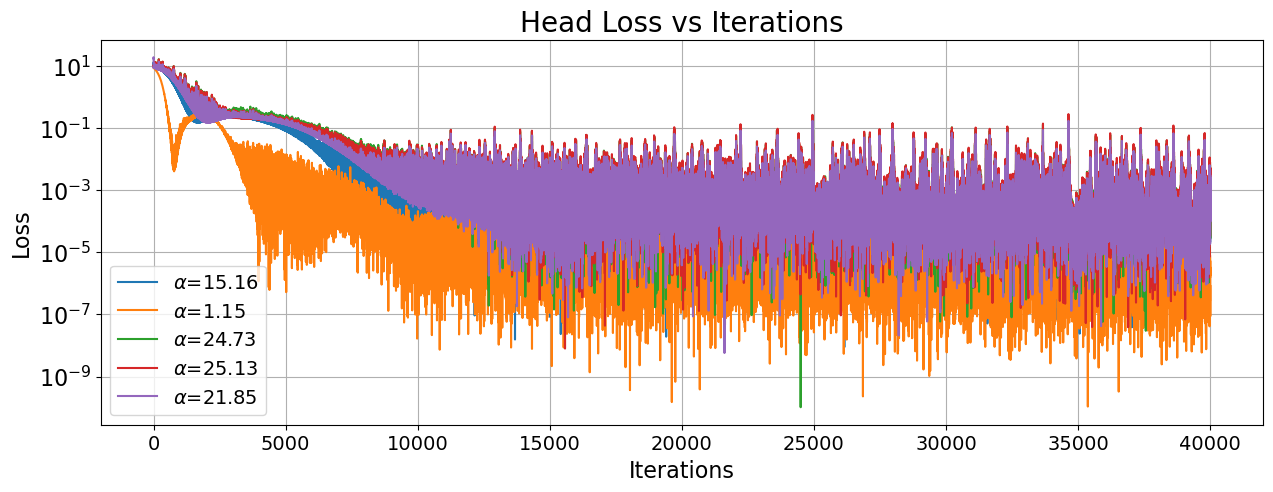

In [104]:
plot_head_loss(loss_hist["head"], alpha_list)

In [156]:
model_name = "final_inference"

save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/linear_exemple1/history_final_inference_2121806.json
